In [1]:
import os
os.chdir("..")

In [2]:
import sys
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from datetime import datetime
sys.path.insert(0, os.getcwd())

import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from tqdm import tqdm
import utilities.translator.tfq_translator as tfq_translator
import utilities.evaluator.evaluator as tfq_evaluator
import utilities.variational.tfq.variational as tfq_minimizer
import utilities.simplification.simplifier as penny_simplifier
import utilities.simplification.misc as simplification_misc#.kill_and_simplify
import utilities.simplification.tfq.gate_killer as tfq_killer
import utilities.database.database as database
import utilities.database.templates as templates
import utilities.mutator.idinserter as idinserter
import running.misc.misc as miscrun
import argparse
import ast
import pickle

from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
ncores=8
js = list(np.logspace(-5,-3,ncores))


def load_ev_HEA(ns, itraj=1,nq=8):

    args = {"problem":"TFIM", "params":"[1.,1.]","nrun":0, "shots":0, "epochs":500, "n_qubits":nq, "vans_its":200,"itraj":itraj, "noisy":True,
            "noise_strength":ns, "acceptange_percentage": 0.01, "L_HEA":1,"run_name":"HEA_fixed","noise_model":"aer"}
    args = miscrun.FakeArgs(args)
    L_HEA = args.L_HEA
    problem = args.problem
    params = ast.literal_eval(args.params)
    shots = miscrun.convert_shorts(args.shots)
    epochs = args.epochs
    n_qubits = args.n_qubits
    learning_rate=1e-4
    acceptange_percentage = args.acceptange_percentage
    noise_strength = args.noise_strength
    int_2_bool = lambda x: True if x==1 else False
    noisy = int_2_bool(args.noisy)
    tf.random.set_seed(abs(args.itraj))
    np.random.seed(abs(args.itraj))

    translator = tfq_translator.TFQTranslator(n_qubits = n_qubits, initialize="x", noisy=args.noisy, noise_strength = noise_strength, noise_model="aer")#, device_name="forest.numpy_wavefunction")
    translator_killer = tfq_translator.TFQTranslator(n_qubits = translator.n_qubits, initialize="x", noisy=translator.noisy, noise_strength = args.noise_strength, noise_model="aer")
    minimizer = tfq_minimizer.Minimizer(translator, mode="VQE", hamiltonian = problem, params = params, lr=learning_rate, shots=shots, patience=30, max_time_training=600, verbose=0)
    simplifier = penny_simplifier.PennyLane_Simplifier(translator)
    killer = tfq_killer.GateKiller(translator, translator_killer, hamiltonian=problem, params=params, lr=learning_rate, shots=shots, accept_wall = 2/args.acceptange_percentage)
    inserter = idinserter.IdInserter(translator, noise_in_rotations=1e-1, mutation_rate = 1.5)
    args_evaluator = {"n_qubits":translator.n_qubits, "problem":problem,"params":params,"nrun":args.itraj,"name":"HEA_fixed"}
    evaluator = tfq_evaluator.PennyLaneEvaluator(minimizer = minimizer, killer=killer, inserter = inserter, args=args_evaluator, lower_bound=translator.ground, stopping_criteria=1e-3, vans_its=args.vans_its, acceptange_percentage = acceptange_percentage)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    return evaluator

In [4]:
ers = []
costs = {ns:{k:[] for k in range(3)} for ns in js}
for ns in js:
    for itraj in tqdm(range(1,50)):
        try:
            evaluator = load_ev_HEA(ns, itraj=itraj)
            for k in range(3):
                costs[ns][k].append(evaluator.evolution[k][1])
        except Exception:
            ers.append([ns, itraj])

100%|██████████| 49/49 [00:05<00:00,  9.36it/s]


In [7]:
costs_HEA = []
for ns in js:
    l=[]
    for k in range(5):
        try:
            l.append(np.min(costs[ns][k]))
        except Exception:
            pass
    costs_HEA.append(l)
costs_HEA = np.squeeze(np.stack(costs_HEA))
costs_HEA

array([[-10.155475 , -10.132887 , -10.140135 ],
       [-10.131489 , -10.142155 , -10.071633 ],
       [-10.097992 , -10.10942  ,  -9.840659 ],
       [-10.060353 ,  -9.84654  ,  -9.584497 ],
       [ -9.72897  ,  -9.839067 ,  -8.7942295],
       [ -9.287117 ,  -9.259304 ,  -4.604746 ],
       [ -9.045334 ,  -8.594647 ,  -4.038018 ],
       [ -7.9173074,  -7.79856  ,  -1.8801227]], dtype=float32)

In [8]:
def load_ev_vans(ns, itraj=1):

    args = {"problem":"TFIM", "params":"[1.,1.]","nrun":0, "shots":0, "epochs":500, "n_qubits":8, "vans_its":200,"itraj":itraj, "noisy":True,
            "noise_strength":ns, "acceptange_percentage": 0.01, "L_HEA":1,"run_name":"VANS","noise_model":"aer"}
    args = miscrun.FakeArgs(args)
    L_HEA = args.L_HEA
    problem = args.problem
    params = ast.literal_eval(args.params)
    shots = miscrun.convert_shorts(args.shots)
    epochs = args.epochs
    n_qubits = args.n_qubits
    learning_rate=1e-4
    acceptange_percentage = args.acceptange_percentage
    noise_strength = args.noise_strength
    int_2_bool = lambda x: True if x==1 else False
    noisy = int_2_bool(args.noisy)
    tf.random.set_seed(abs(args.itraj))
    np.random.seed(abs(args.itraj))

    translator = tfq_translator.TFQTranslator(n_qubits = n_qubits, initialize="x", noisy=args.noisy, noise_strength = noise_strength, noise_model="aer")#, device_name="forest.numpy_wavefunction")
    translator_killer = tfq_translator.TFQTranslator(n_qubits = translator.n_qubits, initialize="x", noisy=translator.noisy, noise_strength = args.noise_strength, noise_model="aer")
    minimizer = tfq_minimizer.Minimizer(translator, mode="VQE", hamiltonian = problem, params = params, lr=learning_rate, shots=shots, patience=30, max_time_training=600, verbose=0)
    simplifier = penny_simplifier.PennyLane_Simplifier(translator)
    killer = tfq_killer.GateKiller(translator, translator_killer, hamiltonian=problem, params=params, lr=learning_rate, shots=shots, accept_wall = 2/args.acceptange_percentage)
    inserter = idinserter.IdInserter(translator, noise_in_rotations=1e-1, mutation_rate = 1.5)
    args_evaluator = {"n_qubits":translator.n_qubits, "problem":problem,"params":params,"nrun":args.itraj,"name":"VANS"}
    evaluator = tfq_evaluator.PennyLaneEvaluator(minimizer = minimizer, killer=killer, inserter = inserter, args=args_evaluator, lower_bound=translator.ground, stopping_criteria=1e-3, vans_its=args.vans_its, acceptange_percentage = acceptange_percentage)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    return evaluator

In [9]:
js = list(np.logspace(-5,-3,8))
cost_vans={j:[] for j in js}
l={k:0 for k in js}
lens={k:[] for k in js}
evals_pic = {k:[] for k in js}
for j in tqdm(js):
    for i in range(150):
        try:
            evo = load_ev_vans(j, itraj=i)
            evals_pic[j].append([evo.evolution[k][:2] for k in range(len(evo.evolution.keys()))])
            cost_vans[j].append(evo.evolution[evo.get_best_iteration()][1])
            lens[j].append(len(evo.evolution.keys()))
            l[j] +=1
        except Exception:
            pass
opt_vans = np.load("analysis/opts_vans1.npy")
stds = []
for ind, k in enumerate(list(cost_vans.values())[:4]):
    opt_vans[ind] = np.min(k)
    #print(np.min(k), len(k))
    #print(np.argmin(k))
    #stds.append(np.std(k))
stdhea = {}
for j in js:
    
    mm = [np.min(k) for k in list(costs[j].values())]
    stdhea[j] = np.std(list(costs[j].values())[np.argmin(mm)])

100%|██████████| 8/8 [01:15<00:00,  9.41s/it]


In [11]:
opt_vans

array([-10.147932, -10.143445, -10.114792, -10.086072, -10.012074,
        -9.969473,  -9.843126,  -9.410399], dtype=float32)

In [12]:
evaluator.minimizer.noisy = False
ground = tfq_minimizer.compute_lower_bound_cost_vqe(evaluator.minimizer)

dict_keys([1e-05, 1.9306977288832496e-05, 3.727593720314938e-05, 7.196856730011514e-05, 0.00013894954943731373, 0.00026826957952797245, 0.0005179474679231213, 0.001])

In [75]:

os.makedirs("data_paper_noise",exist_ok=True)
with open("analysis/evals_giq.pickle","rb") as f:
    evals_giq=pickle.load(f)
for k in list(evals_giq.keys())[:4]:
    evals_giq[k] = evals_pic[k]
with open("data_paper_noise/evals_8qb_vans.pickle","wb") as f:
    pickle.dump(evals_giq,f)
np.save("data_paper_noise/vans_energy_8qb",opt_vans)
np.save("data_paper_noise/HEA_energy_8qb",costs_HEA)
np.save("data_paper_noise/noise_strengths_8qb",js)
ev_opt= {}
for j,k in evals_8qb_vans.items():
    costs_vans_j = []
    for itraj in k:
        costs_vans_j.append(np.min([itraj[k][1] for k in range(len(itraj))]))
    ind_min_j_vans = np.argmin(costs_vans_j)
    ev_opt[j] = k[ind_min_j_vans]
cost_vans = {j:[] for j in js}
for j in js:
    cost_vans[j].append(evo.evolution[evo.get_best_iteration()][1])
eva = load_ev_vans(js[0], itraj=100)

best_structures_vans = []
cost_vans = {}
for ns in tqdm(js):
    ind_opt_db_j = np.argmin([ev_opt[ns][vans_it][1] for vans_it in range(len(ev_opt[ns]))])
    cost_vans[j] = ev_opt[ns][ind_opt_db_j][0]
    stru=database.describe_circuit(eva.minimizer.translator, ev_opt[ns][ind_opt_db_j][0])   
    best_structures_vans.append(stru)


with open("data_paper_noise/evals_8qb_vans_opt.pickle","wb") as f:
    pickle.dump(ev_opt,f)


structures_HEA = [database.describe_circuit(eva.minimizer.translator, database.concatenate_dbs([templates.hea_layer(evaluator.minimizer.translator)]*L)) for L in range(1,4)]
best_layers_HEA = [np.argmin(costs_HEA[k]) for k,ns in enumerate(js)]

opthea = np.stack([structures_HEA[k] for k in best_layers_HEA])


minj_each_traj = {j:[] for j in js}
for j in js:
    for itraj in evals_giq[j]:
        cost_j_traj=[]
        for k in itraj:
            cost_j_traj.append(k[1])
        minj_each_traj[j].append(np.min(cost_j_traj))


disp_HEA = np.array(list(stdhea.values()))/np.abs(np.array([np.min(k) for k in costs_HEA]))
disp_VANS = np.array([np.std(k) for k in list(minj_each_traj.values())])/np.abs(opt_vans)


np.save("data_paper_noise/structures_vans_8qb",best_structures_vans)
np.save("data_paper_noise/structures_HEA_8qb",structures_HEA)
np.save("data_paper_noise/disp_VANS",disp_VANS)
np.save("data_paper_noise/disp_HEA",disp_HEA)

100%|██████████| 8/8 [00:00<00:00, 595.97it/s]


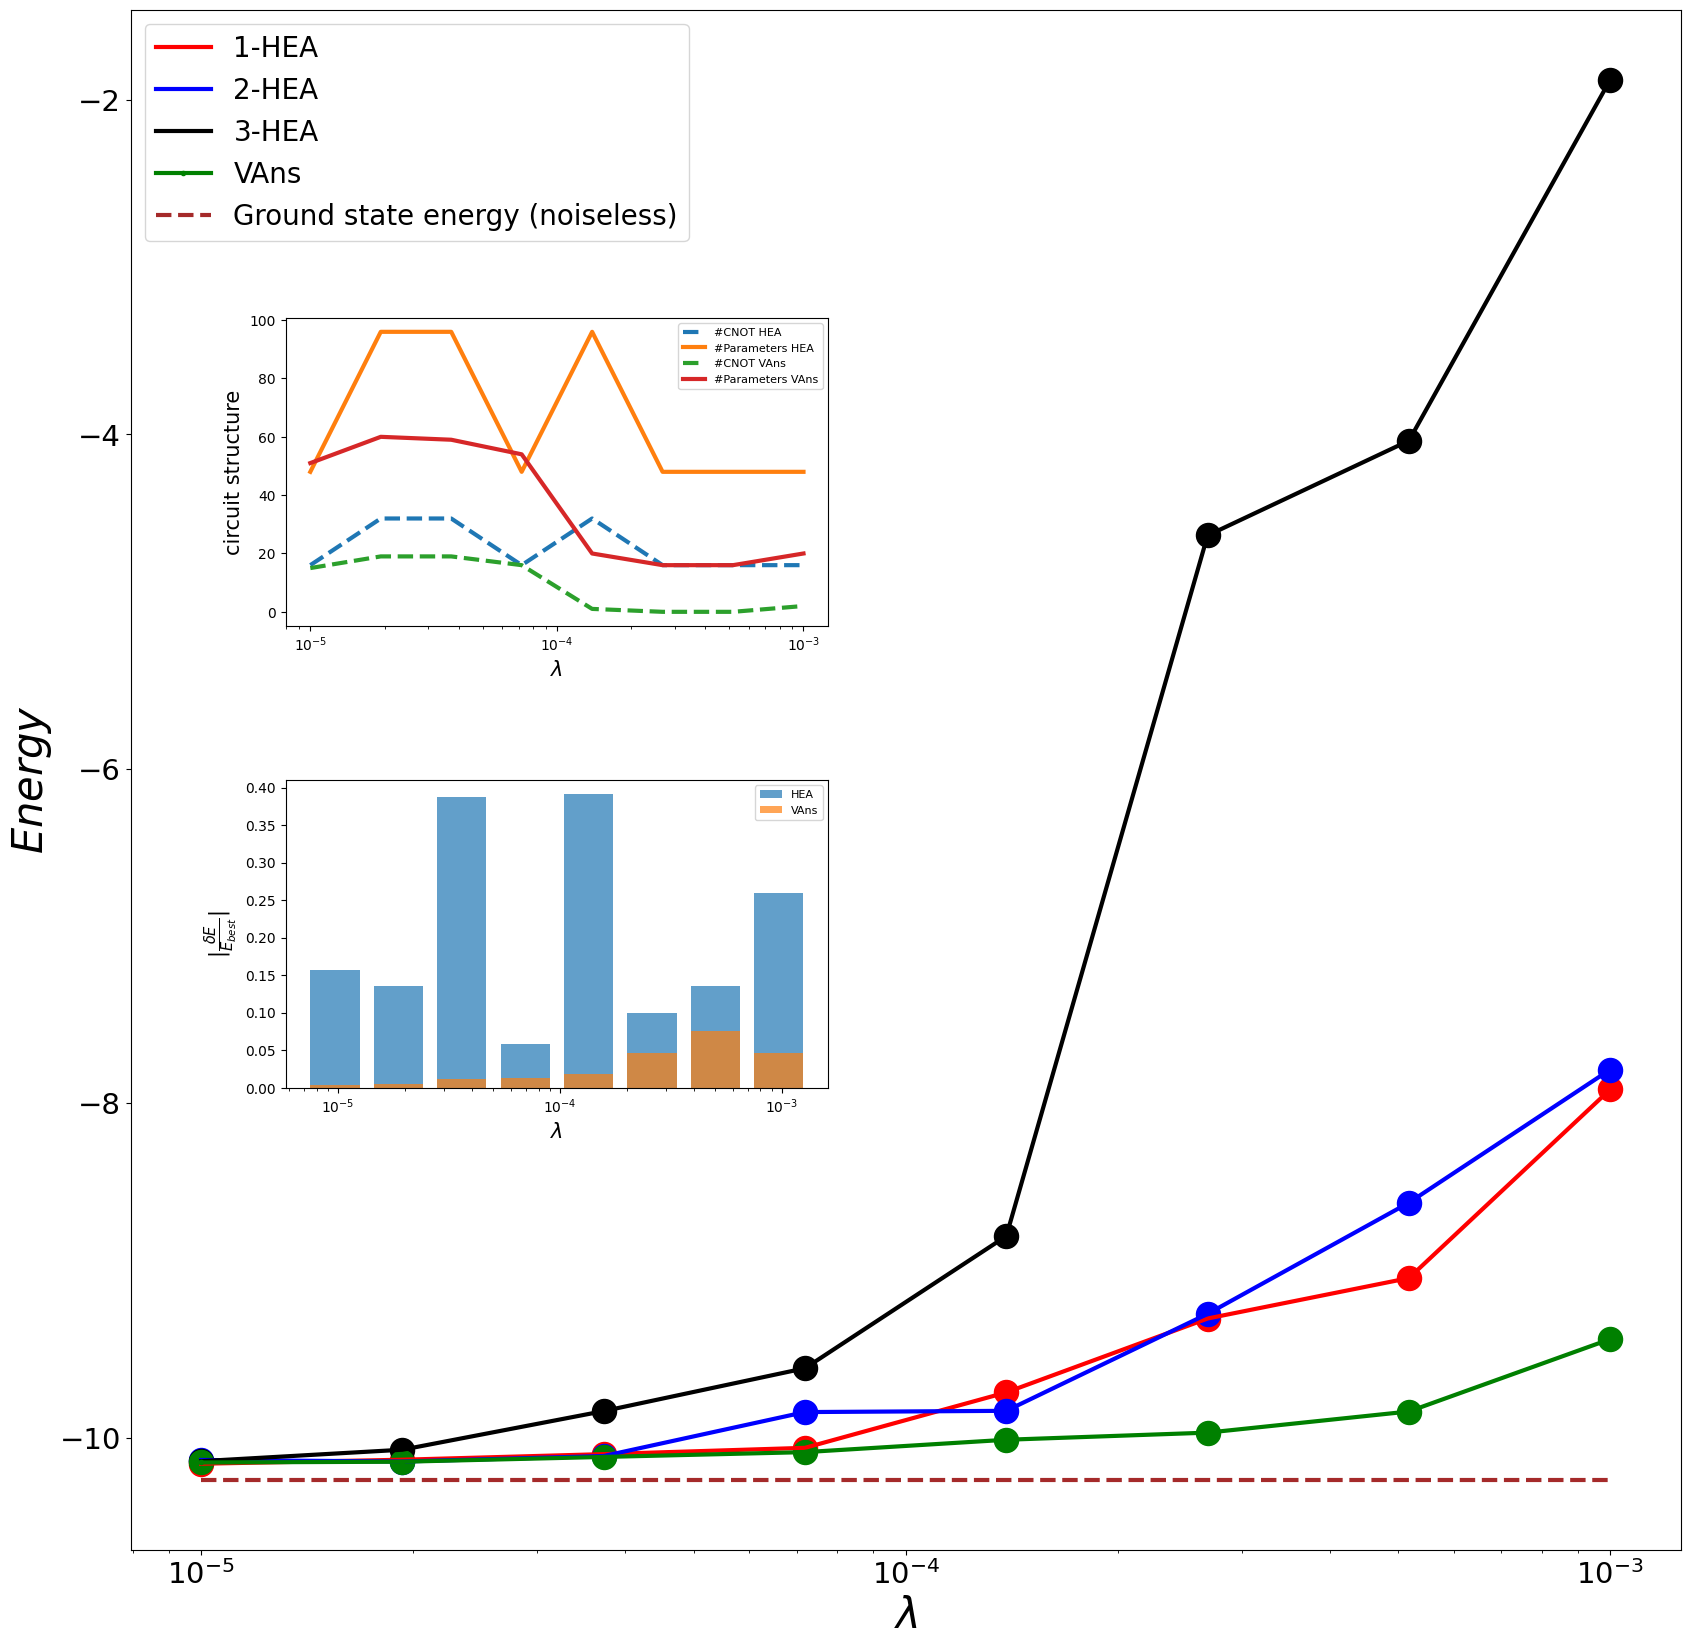

In [81]:
step=1
colors=["red","blue","black"]
plt.figure(figsize=(20,20))
s=30
SS=10*s
ll=3
st=int(.7*s)
ax=plt.subplot()
for k in range(3):
    ax.plot(js,costs_HEA[:,k],'-', color=colors[k], linewidth=ll,label="{}-HEA".format(k+1))
    ax.scatter(js,costs_HEA[:,k],s=SS, color=colors[k])
    
ax.plot(js, opt_vans,'.-',linewidth=ll,color="green", label="VAns")
ax.scatter(js, opt_vans,s=SS,color="green")

ax.plot(js, np.ones(len(opt_vans))*ground,'--',linewidth=ll,color="brown", label="Ground state energy (noiseless)")
ax.set_xlabel(r'$\lambda$',size=s)
ax.set_ylabel(r'$Energy$',size=s)
ax.legend(prop={"size":20})
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelsize=st)
ax.yaxis.set_tick_params(labelsize=st)


axi=ax.inset_axes([.1,.6,.35,.2])
axi.plot(js[::step], opthea[::step,1],'--', linewidth=ll,label="#CNOT HEA")
axi.plot(js[::step], opthea[::step,0],'-', linewidth=ll,label="#Parameters HEA")
axi.plot(js[::step], np.stack(best_structures_vans)[::step,1],'--', linewidth=ll,label="#CNOT VAns")
axi.plot(js[::step], np.stack(best_structures_vans)[::step,0], linewidth=ll,label="#Parameters VAns")
axi.legend(prop={"size":8})
axi.set_xscale("log")
axi.xaxis.set_tick_params(labelsize=int(.5*st))
axi.yaxis.set_tick_params(labelsize=int(.5*st))
axi.set_xlabel(r'$\lambda$',size=int(.5*s))
axi.set_ylabel("circuit structure",size=int(.5*s))


axo=ax.inset_axes([.1,.3,.35,.2])
axo.bar(js, disp_HEA, width=np.array(js)/2, alpha=0.7,label="HEA")
axo.bar(js, disp_VANS, width=np.array(js)/2, alpha=0.7, label="VAns")
axo.set_xscale("log")
axo.set_xlabel(r'$\lambda$',size=int(.5*s))
axo.set_ylabel(r'$|\frac{\delta E}{E_{best}}|$',size=int(.5*s))
axo.legend(prop={"size":8})

plt.savefig("data_paper_noise/8qb_noise.pdf")

In [100]:
len(list(evals_8qb_vans.values())[0])

50

In [102]:
len(list(evals_8qb_vans.values())[0][1])

12

In [107]:
k[0]

50

100%|██████████| 8/8 [00:00<00:00, 617.21it/s]


NameError: name 'vans' is not defined

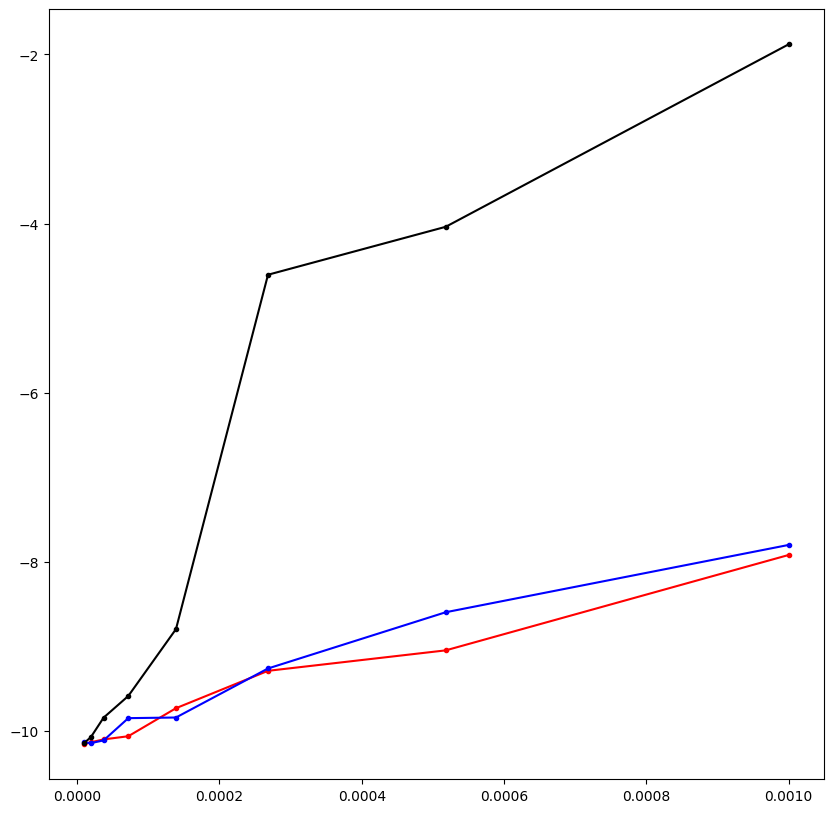

In [60]:
colors=["red","blue","black"]
plt.figure(figsize=(10,10))
ax=plt.subplot()
for k in range(3):
    ax.plot(js,costs_HEA[:,k],'.-', color=colors[k], label="HEA-{}".format(k+1))
ax.plot(js, opt_vans,'.-',color="green", label="vans")
ax.plot(js, np.ones(len(vans))*ground,'--',color="brown", label="ground")

axins = ax.inset_axes([0.5,.45, 0.35, 0.25])

fini=-4
for k in range(2):
    axins.plot(js[:fini],costs_HEA[:,k][:fini],'.-', color=colors[k], label="HEA-{}".format(k+1))
axins.plot(js[:fini], vans[:fini],'.-',color="green", label="vans")
axins.plot(js[:fini], np.ones(len(vans[:fini]))*ground,'--',color="brown", label="ground")
ax.xaxis.set_tick_params(labelsize=0)
axins.set_xticks([])
#axins.set_xscale("log")

mark_inset(ax, axins, loc1=3, loc2=4 ,fc="none", ec="0.5")

ax.set_xlabel(r'$\lambda$',size=10)
ax.set_ylabel(r'$Energy$',size=10)
ax.legend(prop={"size":10})
axins.set_xticks([], [])
axins.set_yticks([ground, np.min(costs_HEA[:fini,1]), np.min(vans[:fini])], [str(np.round(ground,2)), str(np.round(np.min(costs_HEA[:fini,1]),2)),   str(np.round(np.min(vans[:fini]),2))])



In [31]:
def load_ev(ns, itraj=1):

    args = {"problem":"TFIM", "params":"[1.,1.]","nrun":0, "shots":0, "epochs":500, "n_qubits":8, "vans_its":200,"itraj":itraj, "noisy":True,
            "noise_strength":ns, "acceptange_percentage": 0.01, "L_HEA":2,"run_name":""}
    args = miscrun.FakeArgs(args)
    L_HEA = args.L_HEA
    problem = args.problem
    params = ast.literal_eval(args.params)
    shots = miscrun.convert_shorts(args.shots)
    epochs = args.epochs
    n_qubits = args.n_qubits
    learning_rate=1e-4
    acceptange_percentage = args.acceptange_percentage
    noise_strength = args.noise_strength
    int_2_bool = lambda x: True if x==1 else False
    noisy = int_2_bool(args.noisy)
    tf.random.set_seed(abs(args.itraj))
    np.random.seed(abs(args.itraj))

    translator = tfq_translator.TFQTranslator(n_qubits = n_qubits, initialize="x", noisy=args.noisy, noise_strength = noise_strength)#, device_name="forest.numpy_wavefunction")
    translator_killer = tfq_translator.TFQTranslator(n_qubits = translator.n_qubits, initialize="x", noisy=translator.noisy, noise_strength = args.noise_strength)
    minimizer = tfq_minimizer.Minimizer(translator, mode="VQE", hamiltonian = problem, params = params, lr=learning_rate, shots=shots, patience=30, max_time_training=600, verbose=0)
    simplifier = penny_simplifier.PennyLane_Simplifier(translator)
    killer = tfq_killer.GateKiller(translator, translator_killer, hamiltonian=problem, params=params, lr=learning_rate, shots=shots, accept_wall = 2/args.acceptange_percentage)
    inserter = idinserter.IdInserter(translator, noise_in_rotations=1e-1, mutation_rate = 1.5)
    args_evaluator = {"n_qubits":translator.n_qubits, "problem":problem,"params":params,"nrun":args.itraj,"name":""}
    evaluator = tfq_evaluator.PennyLaneEvaluator(minimizer = minimizer, killer=killer, inserter = inserter, args=args_evaluator, lower_bound=translator.ground, stopping_criteria=1e-3, vans_its=args.vans_its, acceptange_percentage = acceptange_percentage)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    return evaluator

In [32]:
ersV = []
costs_vans = {ns:[] for ns in js}
evaluators_vans = {ns:[] for ns in js}
for ns in js:
    for itraj in tqdm(range(1,18)):
        try:
            evaluator = load_ev(ns, itraj=itraj)
            costs_vans[ns].append(evaluator.evolution[evaluator.get_best_iteration()][1])
            evaluators_vans[ns].append(evaluator)
        except Exception:
            ersV.append([ns, itraj])

100%|██████████| 17/17 [00:00<00:00, 20.45it/s]


In [33]:
def get_its(ev):

    it=0
    for k in ev.raw_history.values():
        if k[5] == "mutation":
            it+=1
    return it

In [35]:
[[get_its(ev) for ev in evaluators_vans[ns]] for ns in js]

[[71, 97, 28, 90, 170, 200, 122, 70, 65, 59, 30, 47, 22, 58, 154, 196, 154],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [22]:
[ev.get_best_iteration() for ev in best_evs.values()]

NameError: name 'best_evs' is not defined

In [ ]:
evi = best_evs[js[-1]]
bb = evi.get_best_iteration()
db = evi.evolution[bb][0]
evi.minimizer.translator.give_circuit(db, unresolved=False)[0]

In [ ]:
[[ev.get_best_iteration() for ev in evaluators_vans[ns]] for ns in js]

In [23]:
mean_costs_vans = np.array([np.mean(costs_vans[ns]) for ns in js])
std_costs_vans = np.array([np.std(costs_vans[ns]) for ns in js])

In [24]:
best_costs_vans = [np.min(costs_vans[ns]) for ns in js]

In [38]:
best_costs_HEA = np.array([np.min(costs[ns][best_layers_HEA[ind]]) for ind,ns in enumerate(js)])


In [37]:
mean_costs_HEA =  np.array([np.mean(costs[ns][best_layers_HEA[ind]]) for ind,ns in enumerate(js)])
std_costs_HEA =  np.array([np.std(costs[ns][best_layers_HEA[ind]]) for ind,ns in enumerate(js)])

NameError: name 'best_costs_HEA' is not defined

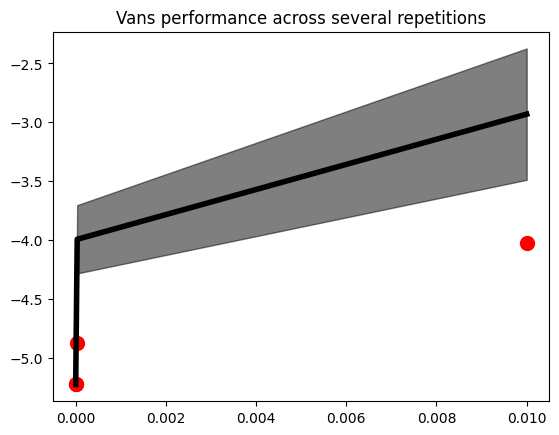

In [27]:
ax=plt.subplot()
ax.set_title("Vans performance across several repetitions")
ax.scatter(js+1e-8,best_costs_vans,s=100, color="red", label="best VANs")
ax.plot(js+1e-8,mean_costs_vans, linewidth=4,label="mean VANs",color="black")
ax.fill_between(js+1e-8,mean_costs_vans- std_costs_vans*.5, mean_costs_vans+std_costs_vans*.5, alpha=0.5, color="black")

ax.scatter(js+1e-8,best_costs_HEA,s=100, color="blue", label="best HEA")
ax.plot(js+1e-8,mean_costs_HEA,linewidth=4, label="mean HEA",color="green")
ax.fill_between(js+1e-8,mean_costs_HEA- std_costs_HEA*.5, mean_costs_HEA+std_costs_HEA*.5, alpha=0.5, color="green")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Noise strength")
ax.set_ylabel("Energy attained")

In [ ]:
wheres = [np.argmin(costs_vans[ns]) for k,ns in enumerate(js)]
best_structures_vans = [database.describe_circuit(best_evs[ns].minimizer.translator, best_evs[ns].evolution[best_evs[ns].get_best_iteration()][0]) for ns in js]
structures_HEA = [database.describe_circuit(evaluator.minimizer.translator, database.concatenate_dbs([templates.hea_layer(evaluator.minimizer.translator)]*L)) for L in range(1,6)]
best_evs = {ns: evaluators_vans[ns][wheres[k]] for k,ns in enumerate(js)}
#[best_evs[ns].minimizer.translator.noise_strength for ns in js] CHECK -it's ok- :)

In [32]:
structures_HEA

[(8, 4), (16, 8), (24, 12), (32, 16), (40, 20)]

In [33]:
best_structures_vans

[(82, 42), (33, 7), (8, 0), (7, 1)]

In [34]:
costs_HEA

[[-4.2360682, -4.6530137, -5.2262187, -5.2261543, -5.2257],
 [-4.236068, -4.653042, -5.111307, -5.1303635, -5.1496525],
 [-3.3369713, -1.1453906, -2.3404398, -1.9385116, -2.1720276],
 [-1.8416083, -0.89300036, -1.4509408, -1.120964, -0.96393454]]

In [35]:
best_layers_HEA = [np.argmin(costs_HEA[k]) for k,ns in enumerate(js)]

Text(0, 0.5, '# Cnots')

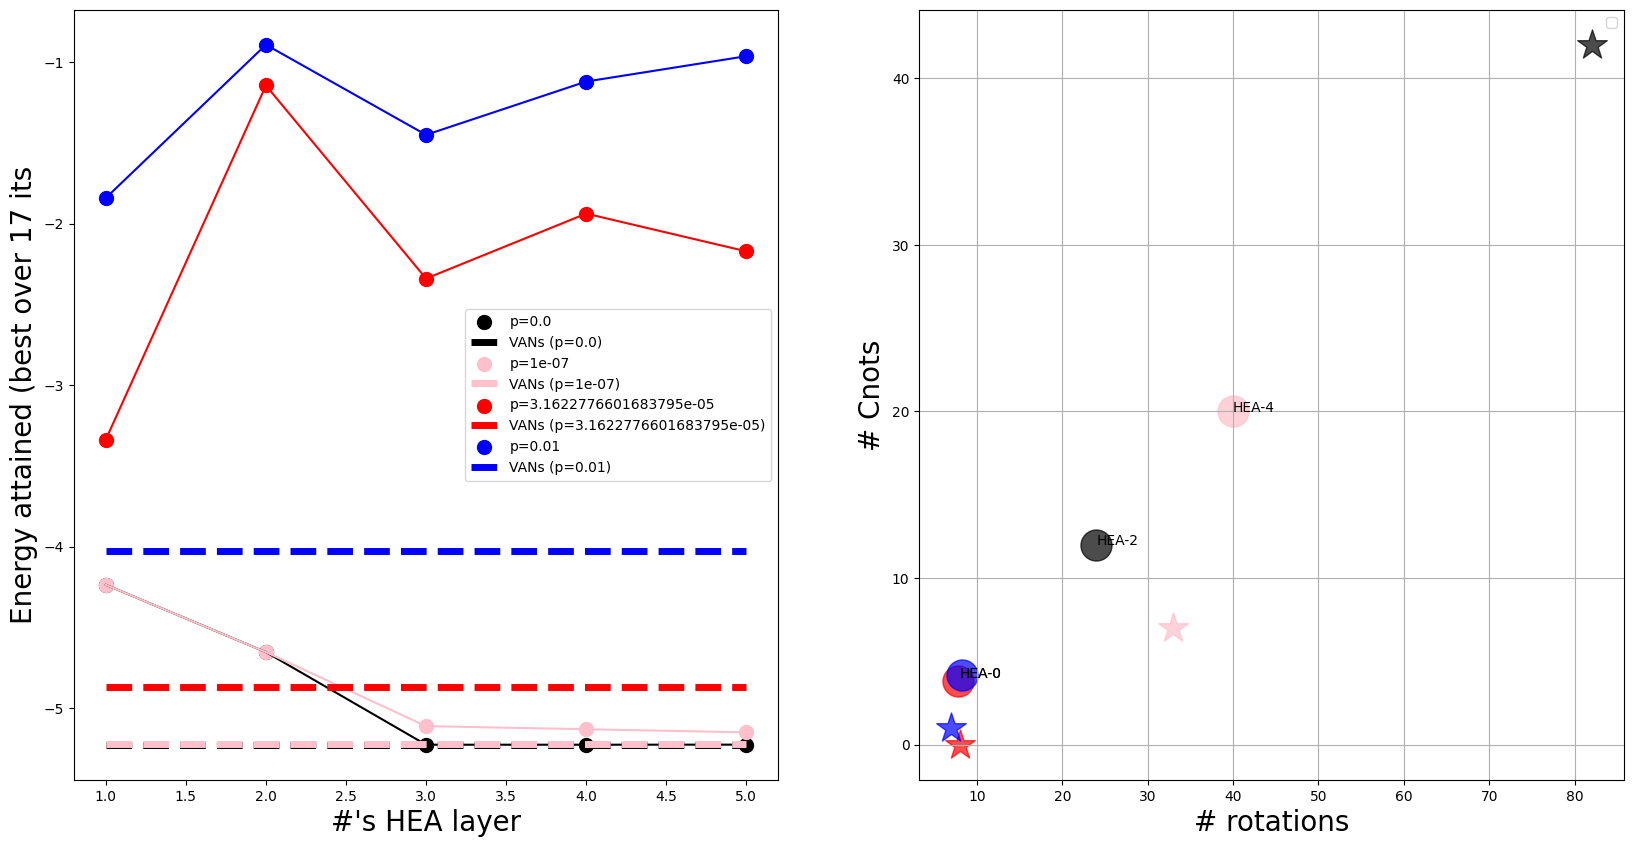

In [36]:
colors = ["black", "pink", "red", "blue"]
plt.figure(figsize=(20,10))
ax=plt.subplot(121)
for ind,k in enumerate(costs_HEA):
    ax.plot(range(1,6),k,'-', c=colors[ind])
    ax.scatter(range(1,6),k,s=100, c=colors[ind], label="p={}".format(js[ind]))
    ax.plot(range(1,6), np.ones(len(range(1,6)))*best_costs_vans[ind],'--',linewidth=5,c=colors[ind], label="VANs (p={})".format(js[ind]))
ax.legend()
ax.set_xlabel("#'s HEA layer",size=20)
ax.set_ylabel("Energy attained (best over {} its".format(17),size=20)

ax=plt.subplot(122)
for ind,k in enumerate(costs_HEA):
    ax.scatter(*(structures_HEA[best_layers_HEA[ind]]+ [0.,0,-.2,.2][ind]*np.array([1,1])), s=500,marker="o", alpha=0.7, c=colors[ind])
    ax.scatter(*best_structures_vans[ind], marker="*", s=500, alpha=0.7,c=colors[ind])
    ax.annotate('HEA-{}'.format(best_layers_HEA[ind]), structures_HEA[best_layers_HEA[ind]])
    #ax.scatter(range(1,6),k,s=100, c=colors[ind], label="p={}".format(js[ind]))
    #ax.axhline(best_costs_vans[ind],c=colors[ind])
ax.legend()
ax.grid()
ax.set_xlabel("# rotations",size=20)
ax.set_ylabel("# Cnots", size=20)
